# Lattice Fuel study with OpenMC

## Loading Libraires, materials and homemade openMC functions


In [18]:
import openmc
import os 
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys 
from PIL import Image
import numpy as np


CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))

from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, WATER_MATERIAL
from src.utils.pre_processing.pre_processing import (remove_previous_results, plot_geometry, mesh_tally_dose_plane, mesh_tally_plane, estimate_fissions_and_neutrons, get_mesh_volumes)
from src.utils.post_preocessing.post_processing import load_mesh_tally, load_dammage_energy_tally, load_mesh_tally_dose
from src.utils.common.materials_utils import get_mass_fraction

os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS


In [2]:

material = openmc.Materials([FUEL_MATERIAL, HELIUM_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL, GRAPHITE_MATERIAL, STEEL_MATERIAL, WATER_MATERIAL])
material.export_to_xml()

In [3]:
r_pin_fuel = openmc.ZCylinder(r=3.5)
pin_fuel_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-r_pin_fuel)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+r_pin_fuel)
pin_universe = openmc.Universe(cells=(pin_fuel_fuel_cell, graphite_cell))

r_big_pin_fuel = openmc.ZCylinder(r=5.5)
big_pin_fuel_cell = openmc.Cell(fill=FUEL_MATERIAL, region=-r_big_pin_fuel)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+r_big_pin_fuel)
big_pin_universe = openmc.Universe(cells=(big_pin_fuel_cell, graphite_cell))

pin_helium_cell = openmc.ZCylinder(r=1., boundary_type='vacuum')
helium_cell = openmc.Cell(fill=HELIUM_MATERIAL, region=-pin_helium_cell)
graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL, region=+pin_helium_cell)
pin_helium_universe = openmc.Universe(cells=(helium_cell, graphite_cell))

all_graphite_cell = openmc.Cell(fill=GRAPHITE_MATERIAL)
outer_universe = openmc.Universe(cells=(all_graphite_cell,))

lat = openmc.HexLattice()
lat.center = (0., 0.)
lat.pitch = (12.5,)   # pitch en cm
lat.outer = outer_universe

lat.universes = [
    [pin_helium_universe] * 24, # 5th ring
    [big_pin_universe] * 18,    # 4th ring    
    [pin_universe] * 12,        # 3rd ring
    [big_pin_universe] * 6,     # 2nd ring
    [big_pin_universe]          # 1st ring
]   

outer_surface = openmc.ZCylinder(r=65.)
steel_outer_surface = openmc.ZCylinder(r=75.)  # 1 cm thickness around graphite
height_top_active_part = openmc.ZPlane(z0=100.0)
height_bottom_active_part = openmc.ZPlane(z0=-100.0)

In [4]:
# Main cell: lattice inside graphite cylinder
main_cell = openmc.Cell(
    fill=lat,
    region=(-outer_surface & -height_top_active_part & +height_bottom_active_part)
)

# Steel shell cell: between graphite and steel cylinder
steel_shell_region = (+outer_surface & -steel_outer_surface & -height_top_active_part & +height_bottom_active_part)
steel_shell_cell = openmc.Cell(fill=STEEL_MATERIAL, region=steel_shell_region)

outer_sphere = openmc.Sphere(r=1000.0, boundary_type='vacuum')

# Air region above the cylinder
air_region_above = -outer_sphere & -height_top_active_part
air_cell_above = openmc.Cell(fill=AIR_MATERIAL, region=air_region_above)

# Air region below the cylinder
air_region_below = -outer_sphere & +height_bottom_active_part
air_cell_below = openmc.Cell(fill=AIR_MATERIAL, region=air_region_below)

# Air region surrounding the steel cylinder (radially outside)
air_region_side = -outer_sphere & +steel_outer_surface & -height_top_active_part & +height_bottom_active_part
air_cell_side = openmc.Cell(fill=AIR_MATERIAL, region=air_region_side)

geometry = openmc.Geometry([main_cell, steel_shell_cell, air_cell_above, air_cell_below, air_cell_side])


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

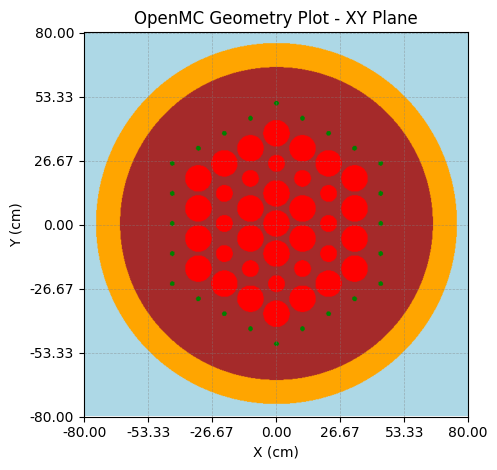

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

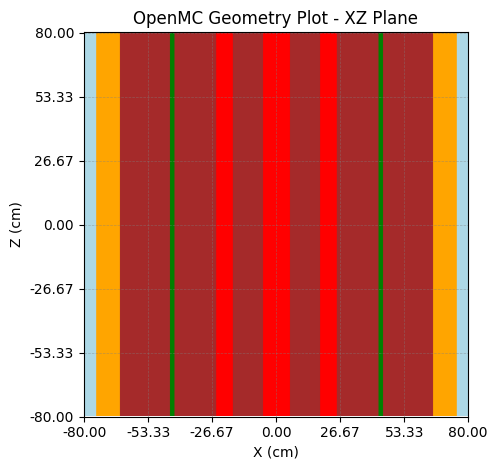

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

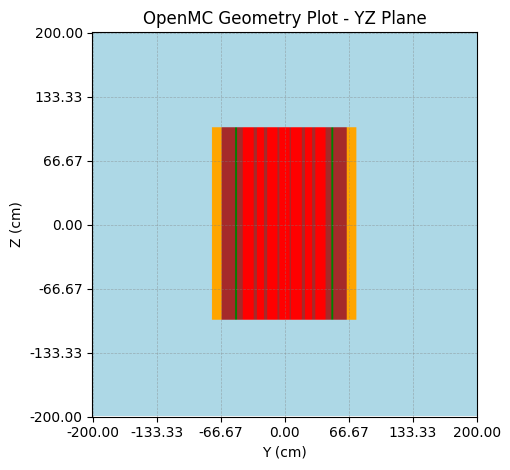

In [5]:

geometry.export_to_xml()

plot_geometry(materials = material, plane="xy", width=160, height=160)

plot_geometry(materials = material, plane="xz", width=160, height=160)

plot_geometry(materials = material, plane="yz", width=400, height=400)


In [6]:
settings = openmc.Settings()
batches_number= 25
settings.batches = batches_number
settings.inactive = 5
settings.particles = 100000
settings.source = openmc.Source()
settings.source.space = openmc.stats.Point((0, 0, 0))
settings.source.particle = 'neutron'
settings.photon_transport = True
settings.source.angle = openmc.stats.Isotropic()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [7]:
# tally pour le flux dans le détecteur
tally = openmc.Tally(name="flux_tally")
tally.scores = ['flux']
tally.filters = [openmc.CellFilter(main_cell)]

# Tally for fission rate
fission_tally = openmc.Tally(name="fission_rate_tally")
fission_tally.scores = ['fission']
fission_tally.filters = [openmc.CellFilter(main_cell)]

# Tally for nu-fission (nu * fission rate)
nu_fission_tally = openmc.Tally(name="nu_fission_rate_tally")
nu_fission_tally.scores = ['nu-fission']
nu_fission_tally.filters = [openmc.CellFilter(main_cell)]

tallies = openmc.Tallies([tally, fission_tally, nu_fission_tally])


In [8]:
mesh_tally_neutron_xy = mesh_tally_plane(name_mesh_tally = "flux_mesh_neutrons_xy", particule_type='neutron', plane='xy',
                                      bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                      thickness= 10.0, coord_value=0.0)
tallies.append(mesh_tally_neutron_xy)

mesh_tally_photon_xy = mesh_tally_plane(name_mesh_tally = "flux_mesh_photons_xy", particule_type='photon', plane='xy',
                                     bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                     thickness= 10.0, coord_value=0.0)
tallies.append(mesh_tally_photon_xy)

mesh_tally_neutron_yz = mesh_tally_plane(name_mesh_tally = "flux_mesh_neutrons_yz", particule_type='neutron', plane='yz',
                                      bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0), 
                                      thickness= 5.0, coord_value=0.0)
tallies.append(mesh_tally_neutron_yz)

mesh_tally_photon_yz = mesh_tally_plane(name_mesh_tally = "flux_mesh_photons_yz", particule_type='photon', plane='yz',
                                     bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                     thickness= 5.0, coord_value=0.0)
tallies.append(mesh_tally_photon_yz)

mesh_tally_neutron_xy_dose = mesh_tally_dose_plane(name_mesh_tally = "flux_mesh_neutrons_xy_dose", particule_type='neutron', plane='xy',
                                           bin_number=500, lower_left=(-100.0, -100.0), upper_right=(100.0, 100.0),
                                           thickness= 10.0, coord_value=0.0)
tallies.append(mesh_tally_neutron_xy_dose)

In [9]:
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=7.
  warn(msg, IDWarning)


In [ ]:
remove_previous_results(batches_number=batches_number)
openmc.run()


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [10]:
statepoint_file = openmc.StatePoint(f'statepoint.{batches_number}.h5')
tally = statepoint_file.get_tally(name="flux_tally")
mean_flux = tally.mean.flatten().tolist()
std_flux = tally.std_dev.flatten().tolist()
# Get fission rate and nu-bar
fission_tally_result = statepoint_file.get_tally(name="fission_rate_tally")
nu_fission_tally_result = statepoint_file.get_tally(name="nu_fission_rate_tally")

fission_rate = float(fission_tally_result.mean.flatten()[0])
nu_fission_rate = float(nu_fission_tally_result.mean.flatten()[0])
nu_bar = nu_fission_rate / fission_rate if fission_rate != 0 else float('nan')

In [11]:
reactor_power = 5e6  # 5 MW in Watts

# Energy released per fission depends on isotope composition
# 19.75% U-235, 80.25% U-238 (by atom fraction)
# Typical energy per fission: U-235 = 202.5 MeV, U-238 = 205.0 MeV

fraction_u235 = get_mass_fraction(FUEL_MATERIAL, "U235")
fraction_u238 = get_mass_fraction(FUEL_MATERIAL, "U238")

In [12]:
fissions_per_second, neutrons_emitted_per_second = estimate_fissions_and_neutrons(reactor_power=reactor_power, nu_bar=nu_bar, fraction_u235=get_mass_fraction(FUEL_MATERIAL, "U235"))

In [13]:
print(f"Fissions per second: {fissions_per_second:.2e}")
print(f"Neutrons emitted per second: {neutrons_emitted_per_second:.2e}")

Fissions per second: 1.53e+17
Neutrons emitted per second: 3.84e+17


In [14]:
print(f"Mean flux: {mean_flux}")
print(f"Standard deviation of flux: {std_flux}")
print(f"Fission rate: {fission_rate:.2e}")
print(f"Nu-fission rate: {nu_fission_rate:.2e}")
print(f"Nu-bar: {nu_bar:.2f}")

Mean flux: [92.24519527314557]
Standard deviation of flux: [0.07740388798629505]
Fission rate: 5.35e-01
Nu-fission rate: 1.35e+00
Nu-bar: 2.52


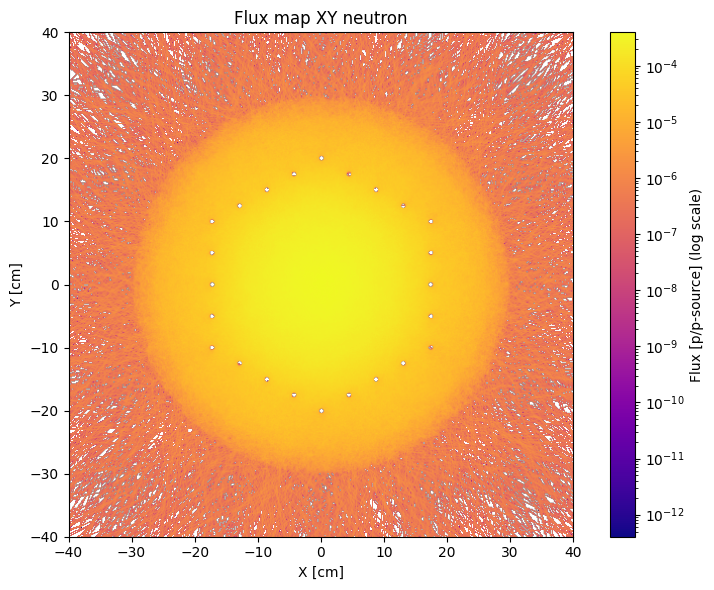

In [ ]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_neutrons_xy",
                bin_number=500, lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), 
                plane="xy", saving_figure=False)

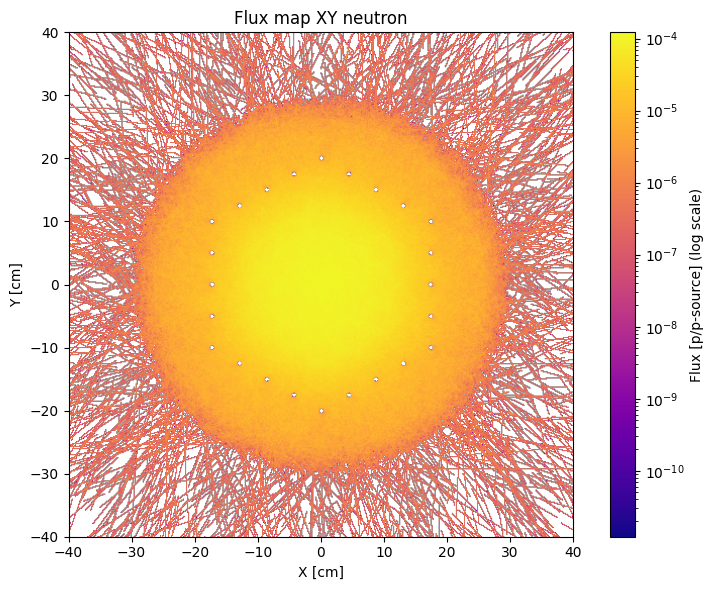

In [23]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_photons_xy",
            bin_number=500, lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), 
            plane="xy", saving_figure=False)


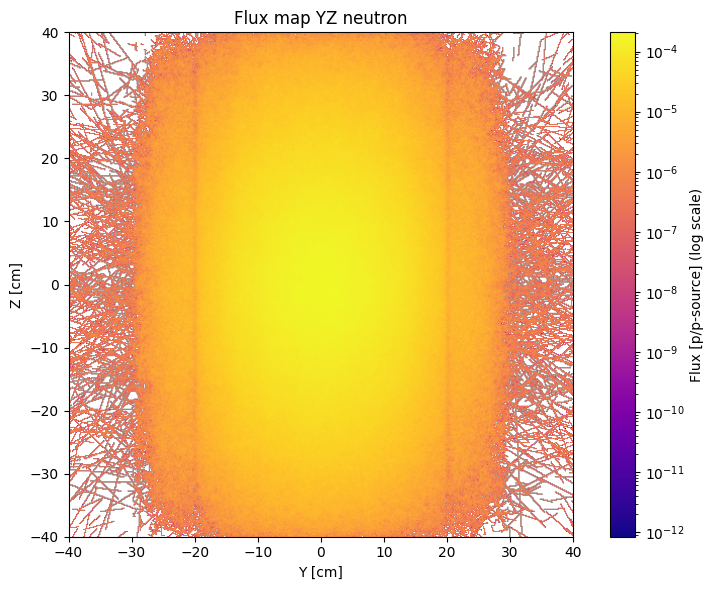

In [24]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_neutrons_yz", bin_number=500,
                lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), plane="yz", 
                saving_figure=False)


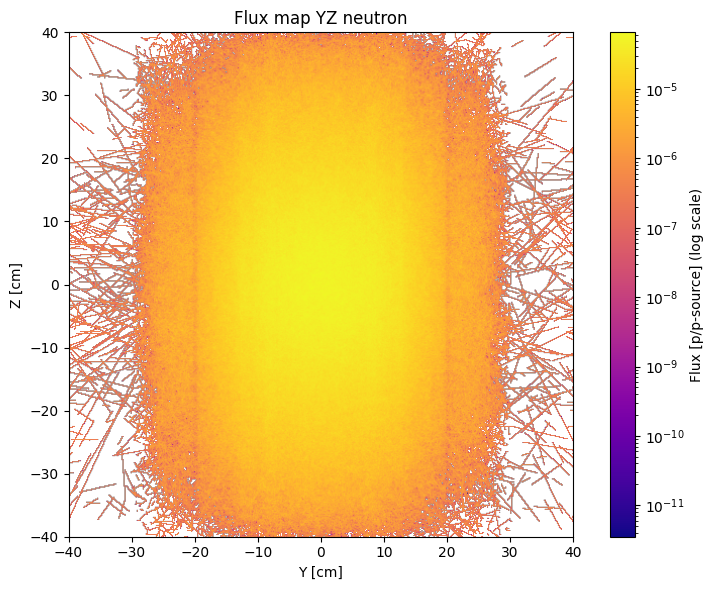

In [25]:
load_mesh_tally(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_photons_yz", bin_number=500,
                lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), plane="yz", 
                saving_figure=False)


In [19]:
mesh_bin_volume = get_mesh_volumes(bin_number=500,
                                    lower_left=(-100.0, -100.0),
                                    upper_right=(100.0, 100.0),
                                    thickness= 10.0,
                                    coord_value=0.0)

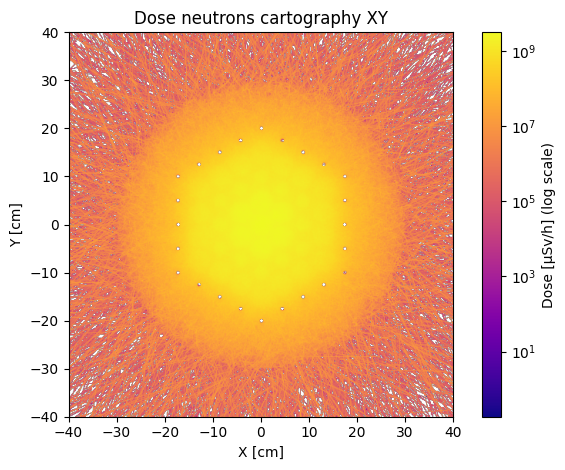

In [20]:
load_mesh_tally_dose(cwd = CWD, statepoint_file = statepoint_file, name_mesh_tally="flux_mesh_neutrons_xy_dose",
                     bin_number=500, lower_left=(-40.0, -40.0), upper_right=(40.0, 40.0), zoom_x=(-40, 40), zoom_y=(-40, 40), 
                     plane="xy", saving_figure=False, n_per_second=neutrons_emitted_per_second, mesh_bin_volume=mesh_bin_volume)